### Bibliotecas

In [112]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import prince
import plotly.io as pio
pio.renderers.default = 'browser'
import plotly.graph_objects as go
import plotly.express as px

## Base de Dados

Os dados são públicos e foram cedidos por um banco português em 2012 de uma pesquisa de marketing realizada no período, há mais de 45 mil observações o que é muito desejável neste tipo de análise pois quanto mais observações mais confiável é o resultado encontrado. Infelizmente gostaria que tivesse mais informações como renda e sexo, entretanto tem o suficiente para rodarmos o modelo e obter resultados interessantes.

https://archive.ics.uci.edu/dataset/222/bank+marketing

In [780]:
data_original = pd.read_csv(r"C:\Users\emanu\OneDrive\Área de Trabalho\bank-full.csv", sep=';')
data_original

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


Abaixo nós transformamos as variáveis 'balance' que calcula o balanço médio anual dos clientes e o 'age' que se refere a idade em variáveis categóricas, criando faixas de idade e faixas de balanços. Optou-se por separar em quintis originando 5 faixas distintas. 

In [840]:
np.percentile(data_original['balance'], [25,50,75])

array([  72.,  448., 1428.])

In [853]:
age_bins = [18, 25, 45, 64, 100]
age_labels = ['young adult', 'adult', 'middle age', 'senior']

balance_bins = [-9000, 0, 110000]
balance_labels = ['Debtor', 'Creditor']

data_original['age_adj'] = pd.cut(data_original['age'], bins=age_bins, labels=age_labels, right=False)
data_original['balance_adj'] = pd.cut(data_original['balance'], bins=balance_bins, labels=balance_labels, right=False)

### Base de Dados Filtrado

In [854]:
data = data_original[['job','age_adj','balance_adj','education']]
data = data[data != 'unknown'].dropna()
data

,job,age_adj,balance_adj,education
0,management,middle age,Creditor,tertiary
1,technician,adult,Creditor,secondary
2,entrepreneur,adult,Creditor,secondary
5,management,adult,Creditor,tertiary
6,management,adult,Creditor,tertiary
...,...,...,...,...
45206,technician,middle age,Creditor,tertiary
45207,retired,senior,Creditor,primary
45208,retired,senior,Creditor,secondary
45209,blue-collar,middle age,Creditor,secondary


In [855]:
for i in data.columns:
    print(data[i].value_counts())
    print('')

job
blue-collar      9278
management       9216
technician       7355
admin.           5000
services         4004
retired          2145
self-employed    1540
entrepreneur     1411
unemployed       1274
housemaid        1195
student           775
Name: count, dtype: int64

age_adj
adult          27820
middle age     13855
senior           789
young adult      729
Name: count, dtype: int64

balance_adj
Creditor    39559
Debtor       3634
Name: count, dtype: int64

education
secondary    23131
tertiary     13262
primary       6800
Name: count, dtype: int64



Abaixo geramos tabelas de contigência para cada par de variáveis, podemos a partir dela já inferir a existência de algumas relações. Por exemplo, clientes idosos ('senior') são em sua maioria aposentados ('retired'), cliente que atuam na área de gestão ('management') possuem melhor educação ('tertiary'), clientes que são donas de casa ('housemaid') possuem educação mais baixa ('primary')

In [856]:
for i in data.columns[1:]:
    print(pd.crosstab(data['job'], data[f'{i}']))
    print('')

age_adj        young adult  adult  middle age  senior
job                                                  
admin.                  89   3459        1441      11
blue-collar            142   6195        2934       7
entrepreneur             5    868         531       7
housemaid                6    516         641      32
management              37   6287        2851      41
retired                  1     64        1416     664
self-employed            9   1029         496       6
services                82   2841        1081       0
student                266    509           0       0
technician              77   5243        2019      16
unemployed              15    809         445       5

balance_adj    Debtor  Creditor
job                            
admin.            476      4524
blue-collar      1060      8218
entrepreneur      108      1303
housemaid          38      1157
management        561      8655
retired           117      2028
self-employed      84      1456
services 

### Teste Qui-Quadrado ($\chi^2$)

O primeiro passo antes de fazer a análise de correspondência é realizar o teste qui-quadrado ($\chi^2$) que serve para saber se há associação estatística significativa entre as variáveis. Em todos os testes que fizemos podemos rejeitar a hipótese nula ($H_0$) e afirmar que há associação estatística significativa entre as variáveis ao nível de significância de 5%. 

In [866]:
tabelas_cross = {}
tab_results = {}

for i in data.columns[1:]:
    tabela_cross = pd.crosstab(data['job'], data[f"{i}"])
    chi2_result = chi2_contingency(tabela_cross)
    
    tabelas_mca[f'tabela_cross_{i}'] = tabela_mca
    tab_results[f'tab_{i}'] = chi2_result
    
    print(f'Variáveis: {data.columns[0]} x {i}')
    print(f'Estatística qui²: {round(chi2_result[0], 2)}')
    print(f'P-valor da estatística: {round(chi2_result[1], 4)}')
    print(f'Graus de liberdade: {chi2_result[2]}')
    print('')

Variáveis: job x age_adj
Estatística qui²: 18385.36
P-valor da estatística: 0.0
Graus de liberdade: 30

Variáveis: job x balance_adj
Estatística qui²: 390.21
P-valor da estatística: 0.0
Graus de liberdade: 10

Variáveis: job x education
Estatística qui²: 26565.66
P-valor da estatística: 0.0
Graus de liberdade: 20



## Análise de Correspondência Múltipla - MCA

A análise de correspondência múltipla (ACM) é utilizada para identificar associação entre variáveis categóricas, neste projeto estaremos trabalhando com uma base de dados pública de um banco português que contem diversas informações de clientes como profissão, idade, educação e entre outros. Será que existe alguma associação entre profissão e educação? A ACM poderá nos ajudará a encontrar esta resposta. 

A biblioteca utilizada é a prince e a principal referência bibliográfico é o livro Manual de Análise de Dados do Favero.

Biblioteca: https://maxhalford.github.io/prince/mca/

In [999]:
mca = prince.MCA(n_components=20).fit(data)
mca

MCA(n_components=20)

Abaixo obtemos o número de variáveis representado pelas colunas na nossa base de dados. O número de categorias é o número de elementos diferentes das nossas variáveis, por exemplo, na variável 'educação' temos três categorias (primary, secundary e tertiary). O número de dimensões é simplesmente a diferença entre o número de variáveis e o número de categorias.

In [871]:
mca.J_

mca.K_

quant_dim = mca.J_ - mca.K_

print(f"Variáveis: {mca.K_}")
print(f"Categorias: {mca.J_}")
print(f"Dimensões: {quant_dim}")

Variáveis: 4
Categorias: 20
Dimensões: 16


### Matriz Binária

Conforme explicado por Favero, a partir da matriz de dados original podemos criar uma matriz binária que indica a presença (1) ou ausência (0) de alguma categoria em uma determinava observação. Por exemplo, na primeira observação o cliente tinha o job (variável) management (categoria) e, portanto, foi assinalado na matriz binária como 1 enquanto as demais profissões receberam o valor 0 visto que o cliente só pode ter uma profissão. 

In [872]:
binaria = pd.get_dummies(data, columns=data.columns, dtype=float)
binaria

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,age_adj_young adult,age_adj_adult,age_adj_middle age,age_adj_senior,balance_adj_Debtor,balance_adj_Creditor,education_primary,education_secondary,education_tertiary
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
45207,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
45208,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
45209,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


### Matriz de Burt

A matriz de burt é o produto da matriz binária (X) pela sua inversa (X.T), é de se notar que essa operação da origem a uma matriz quadrada e simétrica. 

In [945]:
burt = np.matmul(binaria.T, binaria) # pode também ser calculado com o np.dot
burt

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,age_adj_young adult,age_adj_adult,age_adj_middle age,age_adj_senior,balance_adj_Debtor,balance_adj_Creditor,education_primary,education_secondary,education_tertiary
job_admin.,5000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.0,3459.0,1441.0,11.0,476.0,4524.0,209.0,4219.0,572.0
job_blue-collar,0.0,9278.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,142.0,6195.0,2934.0,7.0,1060.0,8218.0,3758.0,5371.0,149.0
job_entrepreneur,0.0,0.0,1411.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,868.0,531.0,7.0,108.0,1303.0,183.0,542.0,686.0
job_housemaid,0.0,0.0,0.0,1195.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,516.0,641.0,32.0,38.0,1157.0,627.0,395.0,173.0
job_management,0.0,0.0,0.0,0.0,9216.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,6287.0,2851.0,41.0,561.0,8655.0,294.0,1121.0,7801.0
job_retired,0.0,0.0,0.0,0.0,0.0,2145.0,0.0,0.0,0.0,0.0,0.0,1.0,64.0,1416.0,664.0,117.0,2028.0,795.0,984.0,366.0
job_self-employed,0.0,0.0,0.0,0.0,0.0,0.0,1540.0,0.0,0.0,0.0,0.0,9.0,1029.0,496.0,6.0,84.0,1456.0,130.0,577.0,833.0
job_services,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4004.0,0.0,0.0,0.0,82.0,2841.0,1081.0,0.0,471.0,3533.0,345.0,3457.0,202.0
job_student,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,775.0,0.0,0.0,266.0,509.0,0.0,0.0,9.0,766.0,44.0,508.0,223.0
job_technician,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7355.0,0.0,77.0,5243.0,2019.0,16.0,636.0,6719.0,158.0,5229.0,1968.0


### Calculo

A análise de correspondência apresenta uma abordagem similar ao PCA, fazemos a decomposição da matriz entretanto por meio da decomposição por valores singular (SVD em inglês). O bruto do cálculo pode ser encontrado no texto abaixo recomendado pelo próprio autor da biblioteca prince que utilizamos.

https://statmath.wu.ac.at/courses/CAandRelMeth/caipA.pdf

In [1001]:
P = (burt/len(burt)).values
n, N = P.shape

r = np.sum(P, axis=1)  
c = np.sum(P, axis=0)  

D_r = np.diag(1 / np.sqrt(r))
D_c = np.diag(1 / np.sqrt(c))

r = r.reshape(-1, 1)  
c = c.reshape(1, -1) 
P_minus_rcT = P - r @ c # O operador @ realiza a mesma operação que np.dot()

# Step 4: Calculate S
S = D_r @ P_minus_rcT @ D_c

print("Matrix S (Standardized Residuals):\n", S)

Matrix S (Standardized Residuals):
 [[ -999.75       -1362.20409631  -531.22499941  -488.87626246
  -1357.64501988  -654.98091575  -554.97747702  -894.87429285
   -393.7003937  -1212.84788824  -504.77717856  -381.82600767
  -2358.73994017 -1664.58880865  -397.23909677  -852.49774239
  -2812.71178873 -1166.18141817 -2150.76221596 -1628.60148603]
 [-1362.20409631 -1855.35        -723.63687026  -665.94924732
  -1849.38960741  -892.21768644  -755.99259256 -1219.0014274
   -536.30028902 -1652.14636156  -687.60954036  -520.12717693
  -3213.08868681 -2267.50395902  -541.12196407 -1161.26830753
  -3831.48982662 -1588.47103026 -2929.81904363 -2218.50817894]
 [ -531.22499941  -723.63687026  -281.95        -259.70329224
   -721.21497489  -347.94223659  -294.8179099   -475.37959569
   -209.14349141  -644.29511872  -268.15025639  -202.8404792
  -1253.02593796  -884.26415787  -211.02241588  -452.87101932
  -1494.18193735  -619.49471363 -1142.56703985  -865.12350654]
 [ -488.87626246  -665.94924732  

In [1002]:
U, S, Vt = np.linalg.svd(S, full_matrices=False)
S

array([3.45534000e+04, 4.33255603e-01, 4.05732706e-01, 3.39947320e-01,
       3.24382617e-01, 2.66081806e-01, 2.52766183e-01, 2.50000000e-01,
       2.50000000e-01, 2.50000000e-01, 2.50000000e-01, 2.39456686e-01,
       2.30618678e-01, 1.63553336e-01, 1.51182980e-01, 1.12920790e-01,
       8.01012943e-02, 1.18864154e-12, 9.59536846e-13, 8.43259010e-14])

In [1003]:
### Autovalores

tabela_autovalores = mca.eigenvalues_summary
tabela_autovalores

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.433,10.83%,10.83%
1,0.406,10.14%,20.97%
2,0.340,8.50%,29.47%
3,0.324,8.11%,37.58%
4,0.266,6.65%,44.24%
5,0.253,6.32%,50.55%
6,0.250,6.25%,56.80%
7,0.250,6.25%,63.05%
8,0.250,6.25%,69.30%


Segundo Fávero "somente é interessante que sejam plotadas no mapa perceptual as coordenadas das dimensões que apresentarem valores de inércia principal parcial superiores à média da inércia principal total por dimensão". No modelo abaixo, acabamos por escolher trabalhar com duas dimensões visto que apenas dois dos autovalores são maiores do a média dos autovalores.

In [860]:
(mca.eigenvalues_).mean()

0.3758295613949093

In [861]:
mca.eigenvalues_

array([0.4332556 , 0.40573271, 0.33994732, 0.32438262])

Abaixo foram geradas as coordenadas padrões para duas dimensões que iremos plotar em um gráfico 2D posteriormente. 

In [862]:
coord_padrao = mca.column_coordinates(data).iloc[:,0:2]/np.sqrt(mca.eigenvalues_[0:2])
coord_padrao

,0,1
job_admin.,0.177194,-1.263625
job_blue-collar,1.258156,-0.468696
job_entrepreneur,-0.609665,0.542039
job_housemaid,1.543336,1.146426
job_management,-1.965169,1.392777
job_retired,3.170110,3.870903
job_self-employed,-0.955095,0.522745
job_services,0.432990,-1.446574
job_student,-0.370206,-2.142034
job_technician,-0.343392,-0.779401


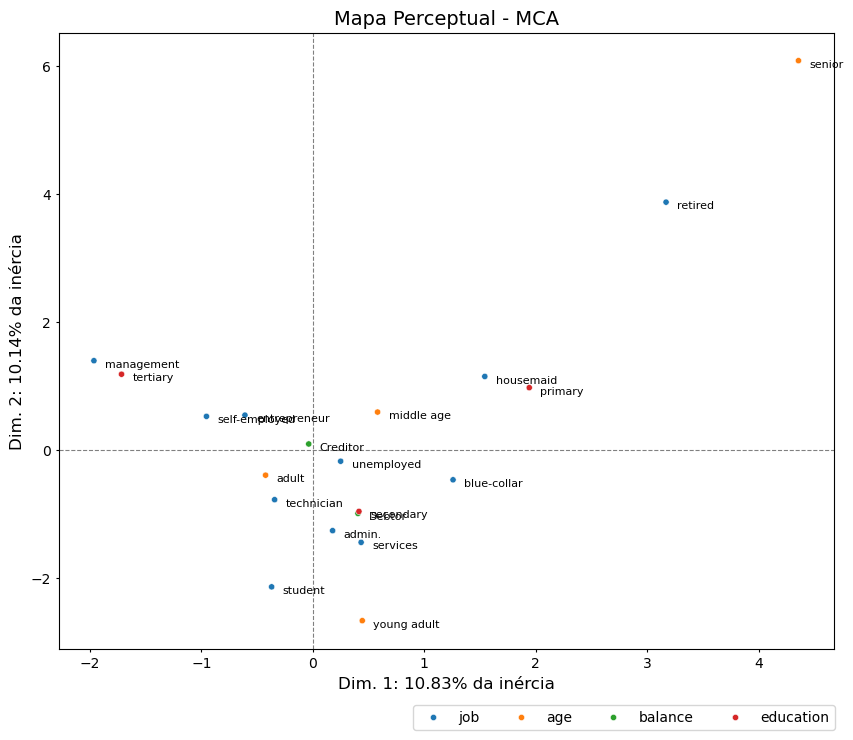

In [1023]:
chart = coord_padrao.reset_index()

var_chart = pd.Series(chart['index'].str.split('_', expand=True).iloc[:,0])


plt.figure(figsize=(10,8))

nome_categ=[]
for col in data:
    nome_categ.append(data[col].sort_values(ascending=True).unique())
    categorias = pd.DataFrame(nome_categ).stack().reset_index()

chart_df_mca = pd.DataFrame({'categoria': chart['index'],
                             'obs_x': chart[0],
                             'obs_y': chart[1],
                             'variavel': var_chart,
                             'categoria_id': categorias[0]})

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + 0.1, point['y'] - 0.1, point['val'], fontsize=8)

label_point(x = chart_df_mca['obs_x'],
            y = chart_df_mca['obs_y'],
            val = chart_df_mca['categoria_id'],
            ax = plt.gca())

sns.scatterplot(data=chart_df_mca, x='obs_x', y='obs_y', hue='variavel', s=20)
plt.axhline(y=0, color='grey', ls='--', linewidth=0.8)
plt.axvline(x=0, color='grey', ls='--', linewidth=0.8)
plt.tick_params(size=2, labelsize=10)
plt.legend(bbox_to_anchor=(1.01,-0.08), fancybox=True, shadow=False, ncols=7, fontsize='10')
plt.title("Mapa Perceptual - MCA", fontsize=14)
plt.xlabel(f"Dim. 1: {tabela_autovalores.iloc[0,1]} da inércia", fontsize=12)
plt.ylabel(f"Dim. 2: {tabela_autovalores.iloc[1,1]} da inércia", fontsize=12)
plt.show()

In [1037]:
chart_df_mca['Cores'] = pd.DataFrame(pd.factorize(chart_df_mca['variavel'])[0])

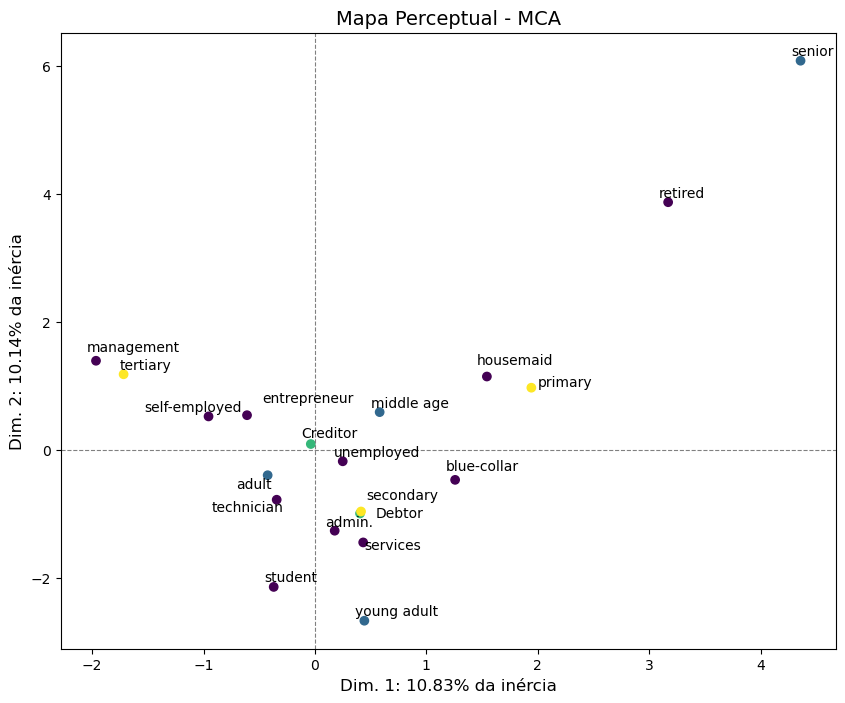

In [1043]:
from adjustText import adjust_text

plt.figure(figsize=(10,8))

plt.scatter(chart_df_mca.iloc[:,1], chart_df_mca.iloc[:,2], c = chart_df_mca['Cores'])

texts = [] 
for i, txt in enumerate(chart_df_mca['categoria_id']):
    texts.append(plt.text(chart_df_mca.iloc[i, 1], chart_df_mca.iloc[i, 2], txt, ha='center'))

plt.axhline(y=0, color='grey', ls='--', linewidth=0.8)
plt.axvline(x=0, color='grey', ls='--', linewidth=0.8)
plt.xlabel('Volatilidade')
plt.ylabel('Retorno Anualizado')
plt.title('Dados Agrupados - Hierárquico (Euclidean - Complete Linkage)', fontsize=14)
plt.title("Mapa Perceptual - MCA", fontsize=14)
plt.xlabel(f"Dim. 1: {tabela_autovalores.iloc[0,1]} da inércia", fontsize=12)
plt.ylabel(f"Dim. 2: {tabela_autovalores.iloc[1,1]} da inércia", fontsize=12)
adjust_text(texts)